## Vehicle Detection and Tracking Project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (SVM or Decision Trees)
* Apply a color transform and append binned color features to the HOG feature vector.
* Experiment training your classifier on HOG / color features only, and then combination of the two
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Using a Decision Tree classifier, explore the feature importances and consider pruning or adding new features.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Estimate a bounding box for vehicles detected.
* Run your pipeline on a video stream and implement tracking to follow detected vehicles.
* Estimate distance and trajectory of detected vehicles.
---
## Step 1: make a list of images to read in

Data set includes a count of 8792  cars and 8968  non-cars


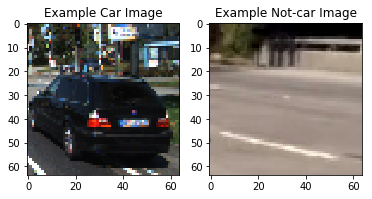

In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# images are divided up into vehicles and non-vehicles folders (each of wich contains subfolder)
# First locate vehicle images
basedir = 'vehicles/'
# Different folders represent different sources for images e.g. GTI, Kitti, generated from video
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

# Do the same thing for non-vehicle images
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(cars[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Data set includes a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

In [2]:
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# NOTE: the last import is only valid for scikit-learn version >= 0.18
# for scikit-learn <= 0.18 use:
# from sklearn.cross_validation import train_test_split


In [3]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features
    
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# I opted to get rid of bin range altogether and let it be automatic
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels seperately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


In [5]:
# Define feature parameters
color_spaces = ['RGB','HSV','LUV','HLS','YUV','YCrCb','LAB'] # 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
spatial_sizes = [(8,8), (16,16), (32,32)] # (32,32) # Spatial binning dimensions
hist_bin_sizes = [16, 32] # 32 # Number of histogram bins

for hist_bins in hist_bin_sizes:
    print('hist_bins:',hist_bins)
    color_space = 'YCrCb'
    spatial_size = (32,32)
    #hist_bins = 32
    t=time.time()
    n_samples = 2000

    random_idxs = np.random.randint(0,len(cars), n_samples)
    test_cars = np.array(cars)[random_idxs]
    test_notcars = np.array(notcars)[random_idxs]

    car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                                    hist_bins=hist_bins)

    notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                                       hist_bins=hist_bins)
          
    print(time.time()-t,'Seconds to compute features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    print('Using spatial binning of:', spatial_size,
          'and', hist_bins, 'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    print(round(time.time()-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print()


hist_bins: 16
8.927541971206665 Seconds to compute features...
Using spatial binning of: (32, 32) and 16 histogram bins
Feature vector length: 3120
4.88 Seconds to train SVC...
Test Accuracy of SVC =  0.945

hist_bins: 32
9.133484840393066 Seconds to compute features...
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 3168
4.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9462

